In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from IPython.display import display, clear_output
import logging
logging.getLogger('tensorflow').disabled = True



In [4]:
def load_cdf():
    figs = np.loadtxt("cfd/figs")
    labels = np.loadtxt("cfd/labels", dtype={"names":("class",), "formats": ("S2",)})
    label_names = [l[0].decode("UTF-8") for l in labels]
    label_cats = np.unique(label_names)
    labels = np.hstack([np.squeeze(np.argwhere(l==label_cats)) for l in label_names])
    return figs, labels, label_cats


x_train, y_train, y_labels = load_cdf()


In [5]:
import sys
from stm.stm import STM, RBF2DInterpolation

# Training a GTM with the GTM object

### Constants and Plots

In [6]:
# Model constants ----

x_train = 2*x_train/255 - 1
inp_num = x_train.shape[1:]
inp_side = inp_num[0]
out_num = 10**2
out_side = int(np.sqrt(out_num))
initial_lr = 0.05
initial_sigma = out_side//8
min_sigma =0.7

In [7]:
x = np.arange(out_side)
X, Y = np.meshgrid(x, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

points = np.array([
    [1. , 1. ], 
    [1. , 8. ], 
    [2.5, 4.5],
    [4.5, 2.5],
    [4.5, 6.5],
    [6.5, 4.5],
    [8. , 1. ], 
    [8. , 8. ]])

def gauss(d, s): return np.exp(-0.5*(s**-2)*d**2)

# Scheduling constants ----

x_train = x_train

decay_window = 60.0
data = x_train
data_num = x_train.shape[0]
batches_num = 10
batch_size = data_num // batches_num
epochs = 200
idcs = np.arange(data_num)
inp_width = 152
inp_height = 107
idx=57

### Model

In [8]:
# Model graph ----

dists = keras.layers.Input(shape = [out_num])
stm = STM(out_num, initial_sigma, name="stm")

# the graph for the GTM
inp = keras.layers.Input(shape = inp_num)
stm_out = stm(inp)

model = keras.models.Model(inputs=[inp, dists], outputs=stm_out)
# loss for the som layer. 
# One parameter for an unsupervised-topological map.
model.add_loss(stm.loss(stm_out))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr), metrics=None)
model.summary()

@tf.function
def forward_spread(inp):
    return stm(inp)
    
@tf.function
def backward_spread(out):
    inp = stm.backward(out)
    return inp

model.forward_spread = forward_spread
model.backward_spread = backward_spread


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16264)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
stm (STM)                       (None, 100)          1626401     input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           stm[0][0]                        
_______________________________________________________________________________________

### Training

In [9]:
# iterate epochs ----
losses = []
for epoch in range(epochs):
    np.random.shuffle(idcs)

    # learning rate and sigma annealing
    curr_sigma = initial_sigma*np.exp(-epoch/decay_window)
    curr_rl = initial_lr*np.exp(-epoch/decay_window)
    
    # update learning rate and sigma in the graph 
    keras.backend.set_value(model.get_layer("stm").sigma, curr_sigma)
    keras.backend.set_value(model.optimizer.lr, curr_rl)
    
    # iterate batches ----
    loss = []
    for batch in range(batches_num):
         
        # define current indices
        start_batch = batch * batch_size
        end_batch = (batch + 1) * batch_size
        curr_idcs = idcs[start_batch:end_batch]
        
        # train
        loss_ = model.train_on_batch([data[curr_idcs]])
        loss.append(loss_)

    losses.append(np.mean(loss))
    if epoch % 20 == 0 or epoch == epochs -1:
        clear_output()
        print("epoch: ", epoch)
        print("loss:", losses[epoch])

epoch:  199
loss: 5.072897291183471


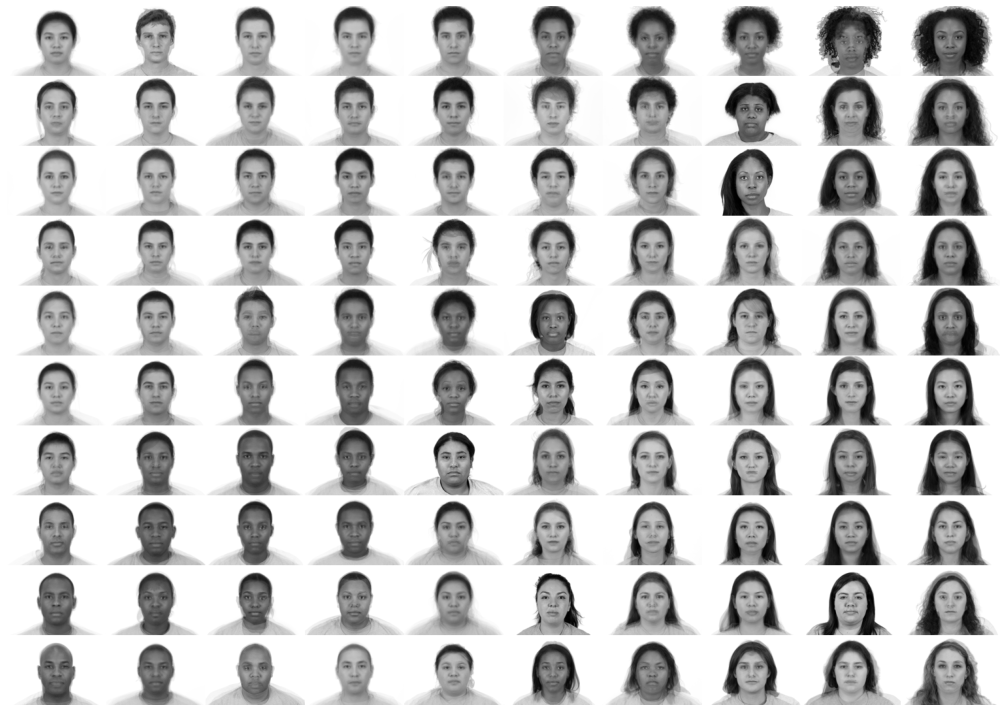

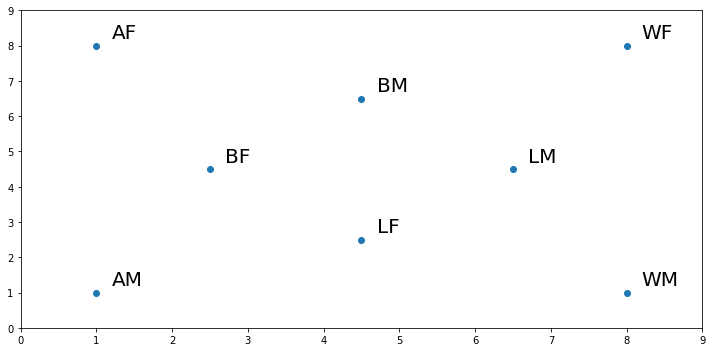

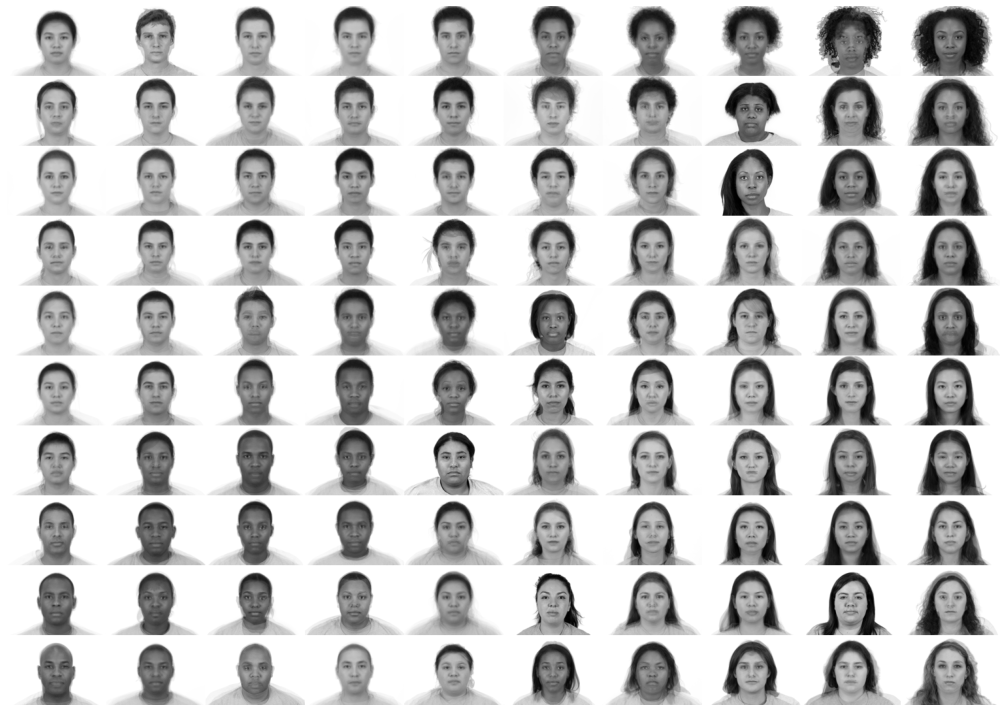

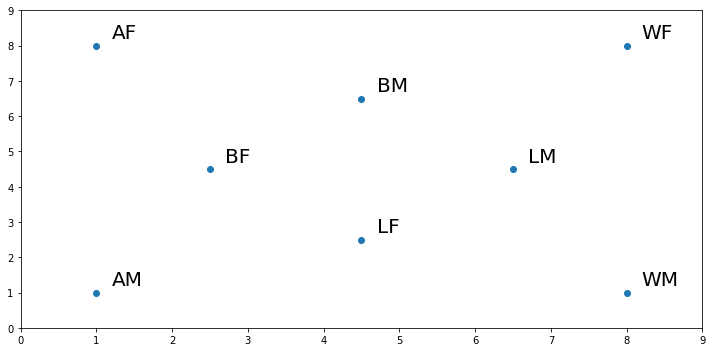

In [10]:
# initialize plots ----
fig1 = plt.figure(figsize=(20, 10))
# The weights plotted as digit prototypes
ax2 = fig1.add_subplot(111, aspect="auto")
w = ax2.imshow(np.random.rand(inp_height, inp_width),vmin=-1, vmax=1, cmap=plt.cm.gray)   
ax2.set_axis_off()


# get current weights  
weights = model.get_layer('stm').kernel.numpy()
# reshape weights so to obtain a matrix of matrices (the actual prototypes)
weights = weights.reshape(inp_width, inp_height, out_side, out_side)\
    .transpose(3,0,2,1).reshape(inp_width*out_side,inp_height*out_side)  
#update weights plot
w.set_data(weights.T)
w.set_clim(weights.min(),weights.max())

# display
fig1.tight_layout()

display(fig1)


In [ ]:
plt.figure(figsize=(8,8))
side = 10
ratio = out_side // side
side_rnd = 7

points = np.random.rand(side_rnd*side_rnd,2)*10
points = points.astype("float32")

outs = RBF2DInterpolation(points, 1.7, side*side).numpy()
generated = model.backward_spread(outs).numpy()

plt.figure(figsize=(18, 13))
for x in range(side_rnd):
    for y in range(side_rnd): 
        
        plt.subplot(side_rnd, side_rnd, x + y*side_rnd +1)
        plt.imshow(generated[x*side_rnd + y].reshape(inp_width, inp_height).T, cmap=plt.cm.gray)
        plt.axis("off")
plt.tight_layout(0.1)
plt.show()